In [19]:
import os
import re
import json
import copy
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

tqdm.pandas()

In [20]:
data_folder = os.path.join('..', '..', 'data')
data_folder

'../../data'

In [21]:
data_path = os.path.join(data_folder, 'mfcc_data')
data_path

'../../data/mfcc_data'

In [22]:
df = {'aa': None, 'ee': None, 'oo': None, 'uu': None, 'yy': None}

In [23]:
for key in tqdm(df.keys(), total=5, desc='compiling dataframe'):
    df[key] = pd.read_csv(os.path.join(data_path, f'{key}.csv'))
    df[key].rename(columns = {'Unnamed: 0':'per_frame_idx'}, inplace = True)

compiling dataframe:   0%|          | 0/5 [00:00<?, ?it/s]

compiling dataframe: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


In [24]:
df['yy'].head()

,per_frame_idx,mb_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,phonon,asthma_status
0,0,Gaurav,44.710414,19.531717,7.328152,8.012278,8.111264,4.881243,3.272635,3.614586,3.929110,4.392023,4.472067,3.018250,yy_0,Control
1,1,Gaurav,19.114588,17.408821,15.060162,12.615221,10.534673,9.048090,8.113040,7.486300,6.866503,6.039954,4.966096,3.772002,yy_0,Control
2,2,Gaurav,21.273338,19.061090,16.062972,12.950587,10.189107,7.952612,6.235261,5.024480,4.375248,4.328725,4.764197,5.339773,yy_0,Control
3,3,Gaurav,23.144851,20.887974,18.016163,15.320787,13.205160,11.590205,10.153748,8.696925,7.354372,6.497358,6.416034,7.031154,yy_0,Control
4,4,Gaurav,30.542365,26.728360,21.410256,15.800419,11.031209,7.835375,6.380029,6.298878,6.894315,7.422906,7.355647,6.524073,yy_0,Control


In [25]:
patients = {'aa': None, 'ee': None, 'oo': None, 'uu': None, 'yy': None}
control = {'aa': None, 'ee': None, 'oo': None, 'uu': None, 'yy': None}

In [26]:
for key, df_t in df.items():
    patients[key] = df_t.loc[df_t['asthma_status'] == 'Patient']
    control[key] = df_t.loc[df_t['asthma_status'] == 'Control']

    n_p = patients[key]['mb_name'].nunique()
    n_c = control[key]['mb_name'].nunique()

    print(f'phonon {key}: p = {n_p}, c = {n_c}')

phonon aa: p = 65, c = 103
phonon ee: p = 65, c = 101
phonon oo: p = 63, c = 103
phonon uu: p = 62, c = 98
phonon yy: p = 62, c = 101


In [27]:
metadata_dir_path = os.path.join(data_folder, 'SHIVANI_DATA_2016')
metadata_dir_path

'../../data/SHIVANI_DATA_2016'

In [28]:
subjects = dict([])

for name in os.listdir(metadata_dir_path):
    name_path = os.path.join(metadata_dir_path, name)
    metadata_path = None

    a, b, c = False, False, False
    for file in os.listdir(name_path):
        if re.match('^.+before.+[.]wav$', file) != None: a = True
        if re.match('^.+before.+[.]anote[.]txt$', file) != None: b = True
        if re.match('^.+[.]json$', file) != None: 
            c = True
            metadata_path = os.path.join(name_path, file)

    if a and b and c:
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)['subjectBiodata']

            # fill deatils about the subjects
            subjects[name] = {
                'age': metadata['subjectAge'],
                'gender': metadata['subjectGender'],
                'type': metadata['subjectType']
            }

#### Visualize

In [29]:
patient_ages = [data['age'] for names, data in subjects.items() if data['type'] == 'Patient']
contol_ages = [data['age'] for names, data in subjects.items() if data['type'] == 'Control']

patient_mean_age = round(np.mean(patient_ages))
control_mean_age = round(np.mean(contol_ages))
print(f'Mean age of contol is {control_mean_age}')
print(f'Mean age of patients is {patient_mean_age}')

patient_median_age = round(np.median(patient_ages))
control_median_age = round(np.median(contol_ages))
print(f'Median age of contol is {control_median_age}')
print(f'Median age of patients is {patient_median_age}')


Mean age of contol is 30
Mean age of patients is 42
Median age of contol is 26
Median age of patients is 40


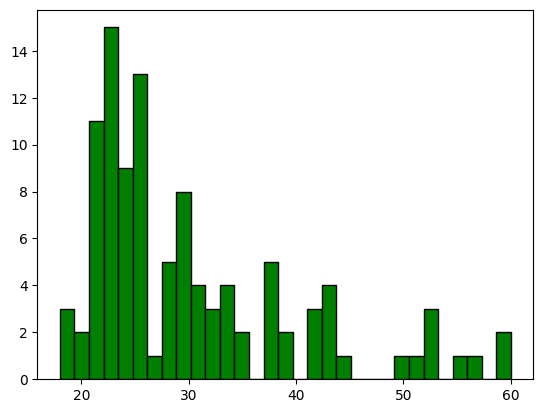

In [30]:
plt.hist(contol_ages, color='green', ec='black', bins=len(set(contol_ages)))
plt.show()

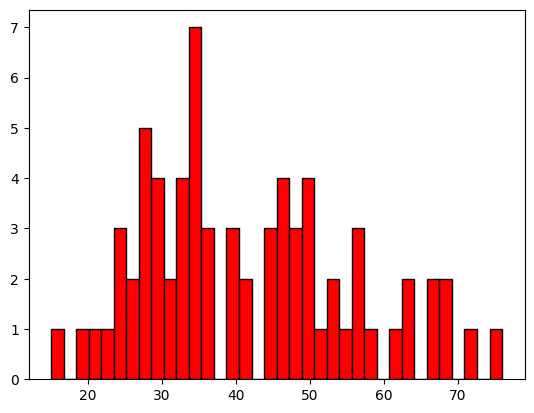

In [31]:
plt.hist(patient_ages, color='red', ec='black', bins=len(set(patient_ages)))
plt.show()

In [32]:
patient_genders = [data['gender'] for names, data in subjects.items() if data['type'] == 'Patient']
contol_genders = [data['gender'] for names, data in subjects.items() if data['type'] == 'Control']

print(f'Gender num for control {Counter(contol_genders)}')
print(f'Gender num for patients {Counter(patient_genders)}')

Gender num for control Counter({'male': 55, 'female': 49})
Gender num for patients Counter({'male': 39, 'female': 31})


#### Make feature matrix

In [33]:
feature_cols = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
def combine_features(row, col_list: list[str]):
    combined_row = np.array([np.float32(row[col]) for col in col_list])
    return combined_row

In [34]:
save_path = os.path.join('..', '..', 'data', 'mfcc_matix_data')

for key, df_t in df.items():
    df_t['f_combined'] = df_t.progress_apply(lambda row: combine_features(row, feature_cols), axis=1)
    df_t.drop(feature_cols, axis=1, inplace=True)

100%|██████████| 748603/748603 [00:19<00:00, 38668.12it/s]


In [42]:
for key, df_t in tqdm(df.items(), total=5, desc='saving to tsv files'):
    df_t.to_csv(os.path.join(save_path, f'{key}.tsv'), header=True, index=False, sep='\t')